## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import csv
# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('snapshots', 'resnet50_csv_20_convert.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'Platelets', 1: 'RBC', 2: 'WBC'}
# labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(12, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(12, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/microsisdcn/.virtualenvs/cv/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### 1. Load CSV

In [3]:
#annotations_file = 'annotations.csv'
annotations_file = 'val_annotations.csv'
cwd = os.getcwd()

image_names = []

with open (os.path.join(cwd, annotations_file)) as csvfile:
    readCSV = csv.reader(csvfile, delimiter='\n')
    for row in readCSV:
        vals = row[0].split(',')
        this_filepath = vals[0]
        image_names.append(this_filepath)
        
## remove duplicates by taking a set
image_names = list(set(image_names))
print(len(image_names))

25


In [4]:
print(image_names[:2])

['./images/test/2020-06-22_16-27-01_CU.jpg', './images/test/2020-06-22_14-15-20_CU.jpg']


In [5]:
score_threshold_retinanet = 0.3
acceptable_box_overlap = 0.3

### 2. Extract Ground Truth Annotations

In [6]:
def get_gt_annotations(filepath):
    gt_ann = []
    with open (os.path.join(cwd, annotations_file)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter='\n')
        for row in readCSV:
            vals = row[0].split(',')
            this_filepath = vals[0]
            
            if this_filepath == filepath:
                record = []
                record.append(int(vals[1]))
                record.append(int(vals[2]))
                record.append(int(vals[3]))
                record.append(int(vals[4]))
                record.append(vals[5])
                
                gt_ann.append(record)
    return gt_ann
    

### 3. IOU Calculations

In [7]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(int(boxA[0]), int(boxB[0]))
	yA = max(int(boxA[1]), int(boxB[1]))
	xB = min(int(boxA[2]), int(boxB[2]))
	yB = min(int(boxA[3]), int(boxB[3]))
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (int(boxA[2]) - int(boxA[0]) + 1) * (int(boxA[3]) - int(boxA[1]) + 1)
	boxBArea = (int(boxB[2]) - int(boxB[0]) + 1) * (int(boxB[3]) - int(boxB[1]) + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [8]:
def highest_iou(predicted_box, gt_ann):
    
    highest_iou = 0
    best_match = []
    for each_gt in gt_ann:
        this_iou = bb_intersection_over_union(predicted_box[:-1], each_gt[:-1])
#         print(" For this box is: ", this_iou)
        if this_iou > highest_iou:
            highest_iou = this_iou
            best_match = each_gt
            
    return highest_iou, best_match
        

In [9]:
def accuracy(gt_ann, predicted_ann):
    true_positive = []
    class_mismatch = []
    false_positive = []
    false_negative = []
    
    predicted_ann_copy = predicted_ann.copy()
    gt_ann_copy = gt_ann.copy()
    
    for each_pred in predicted_ann_copy:
        # 1. Calculate the highest_iou with any gt_box
        best_iou, best_gt_match = highest_iou(each_pred, gt_ann_copy)
#         print("Best IOU is: ", each_pred, best_gt_match, best_iou)
        
        ## If this box has a match
        if best_iou >= acceptable_box_overlap:
            ## if class label matches
            if best_gt_match[-1] == each_pred[-1]:
                ## This is a true positive
                true_positive.append(each_pred)
                ## remove this from predicted ann and gt
#                 print("Predicted Ann before:", predicted_ann)
                predicted_ann.remove(each_pred)
#                 print("Predicted Ann after:", predicted_ann)
                if best_gt_match in gt_ann:
                    gt_ann.remove(best_gt_match)
            elif best_gt_match[-1] != each_pred[-1]:
                ## this is a class mismatch
                class_mismatch.append(each_pred)
                ## remove this box
                predicted_ann.remove(each_pred)
                if best_gt_match in gt_ann:
                    gt_ann.remove(best_gt_match)
        
    ## If IOU is less than 0.5, leave as is

    ## Any predicted box is now false positive
    for remain_pred in predicted_ann:
        false_positive.append(remain_pred)

    ## Any remaining gt box is false negative
    for remain_gt in gt_ann:
        if remain_gt[-1] in ['Platelets','RBC','WBC']:
            false_negative.append(remain_gt)

    return true_positive, class_mismatch, false_positive, false_negative       

### 3. Draw Predicted and GT Annotations

In [10]:
def run_detection_image(filepath):
    image = read_image_bgr(filepath)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale
    
    gt_ann = get_gt_annotations(filepath)
    num_gt_ann = len(gt_ann)
    
    predicted_ann = []

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < score_threshold_retinanet:
            break
        record = []
        record.append(int(box[0]))
        record.append(int(box[1]))
        record.append(int(box[2]))
        record.append(int(box[3]))
        record.append(labels_to_names[label])
        print("Record is: ", record)
        predicted_ann.append(record)
    
    
#     print("predicted ann are: ", predicted_ann)
    ## Calculate boxes
    true_positive, class_mismatch, false_positive, false_negative = accuracy(gt_ann, predicted_ann)
    print(len(true_positive), len(class_mismatch), len(false_positive), len(false_negative))
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    ## Draw theses on the image
    ## Draw true positive in green
    if len(true_positive) > 0:
        for each_true in true_positive:
            cv2.rectangle(draw,(each_true[0],each_true[1]),(each_true[2],each_true[3]),(0,255,0),3) #green
            cv2.putText(draw, each_true[-1], (each_true[0]-2, each_true[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
        
    ## Draw class mismatch in light blue   
    if len(class_mismatch) > 0:
        for each_mismatch in class_mismatch:
            cv2.rectangle(draw,(each_mismatch[0],each_mismatch[1]),(each_mismatch[2],each_mismatch[3]),(255,255,0),3) #green
            cv2.putText(draw, each_mismatch[-1], (each_mismatch[0]-2, each_mismatch[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
        
    
     ## Draw false positive  in blue 
    if len(false_positive) > 0:
        for each_fp in false_positive:
            cv2.rectangle(draw,(each_fp[0],each_fp[1]),(each_fp[2],each_fp[3]),(255,0,0),3) #green
            cv2.putText(draw, each_fp[-1], (each_fp[0]-2, each_fp[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
    
    
     ## Draw false negative in red 
    if len(false_negative) > 0:
        for each_fn in false_negative:
            cv2.rectangle(draw,(each_fn[0],each_fn[1]),(each_fn[2],each_fn[3]),(0,0,255),3) #green
            cv2.putText(draw, each_fn[-1], (each_fn[0]-2, each_fn[1]-2),font, 0.5,
                        (0,0,0),1,cv2.LINE_AA) # text in black
            
            
    ## Add key to the image
    cv2.putText(draw, "True Positive", (1200, 20),font, 0.8, (0,255,0),1,cv2.LINE_AA) 
    cv2.putText(draw, "Class Mismatch", (1200, 50),font, 0.8, (255,255,0),1,cv2.LINE_AA)
    cv2.putText(draw, "False Positive", (1200, 80),font, 0.8, (255,0,0),1,cv2.LINE_AA)
    cv2.putText(draw, "False Negtaive", (1200, 110),font, 0.8, (0,0,2550),1,cv2.LINE_AA)
    
    ### Save this image
    
    file, ext = os.path.splitext(filepath)
    image_name = file.split('/')[-1] + ext
    output_path = os.path.join('examples/results_test/', image_name)
    
    draw_conv = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_path, draw_conv)
    
    return len(true_positive), len(class_mismatch), len(false_positive), len(false_negative), num_gt_ann

#         color = label_color(label)

#         b = box.astype(int)
#         draw_box(draw, b, color=color)

#         caption = "{} {:.3f}".format(labels_to_names[label], score)
#         draw_caption(draw, b, caption)

#     plt.figure(figsize=(15, 15))
#     plt.axis('off')
#     plt.imshow(draw)
#     plt.show()
    


In [11]:
total_true_positive = 0
total_class_mismatch = 0
total_false_positive = 0
total_false_negative = 0
total_gt = 0

In [12]:
for filepath in image_names:
    num_tp, num_cm , num_fp, num_fn, num_gt = run_detection_image(filepath)
    print("Ground Truth: ", num_gt)
    total_true_positive += num_tp
    total_class_mismatch += num_cm
    total_false_positive += num_fp
    total_false_negative += num_fn
    total_gt += num_gt


processing time:  1.4512858390808105
Record is:  [1085, 6, 1180, 120, 'WBC']
Record is:  [812, 546, 905, 634, 'WBC']
Record is:  [896, 0, 971, 73, 'WBC']
Record is:  [543, 645, 647, 749, 'WBC']
Record is:  [407, 129, 472, 187, 'RBC']
Record is:  [782, 733, 892, 841, 'WBC']
Record is:  [435, 181, 528, 270, 'WBC']
Record is:  [341, 286, 400, 345, 'RBC']
Record is:  [612, 814, 670, 870, 'RBC']
Record is:  [352, 221, 415, 284, 'RBC']
Record is:  [130, 322, 195, 391, 'RBC']
Record is:  [768, 835, 830, 902, 'RBC']
Record is:  [236, 455, 302, 526, 'RBC']
Record is:  [745, 458, 807, 525, 'RBC']
Record is:  [886, 839, 1000, 927, 'WBC']
Record is:  [152, 0, 211, 41, 'RBC']
Record is:  [1037, 335, 1118, 409, 'RBC']
Record is:  [337, 920, 410, 958, 'WBC']
Record is:  [1178, 1, 1196, 19, 'Platelets']
Record is:  [840, 889, 859, 906, 'Platelets']
Record is:  [1198, 9, 1215, 26, 'Platelets']
Record is:  [685, 749, 705, 772, 'Platelets']
Record is:  [832, 904, 850, 923, 'Platelets']
Record is:  [979,

processing time:  0.05277109146118164
Record is:  [685, 659, 807, 780, 'WBC']
Record is:  [1015, 550, 1161, 660, 'WBC']
Record is:  [155, 543, 288, 656, 'WBC']
Record is:  [673, 161, 794, 297, 'WBC']
Record is:  [843, 590, 914, 663, 'RBC']
Record is:  [607, 454, 678, 524, 'RBC']
Record is:  [470, 522, 534, 592, 'RBC']
Record is:  [701, 311, 785, 387, 'RBC']
Record is:  [701, 487, 765, 552, 'RBC']
Record is:  [783, 0, 817, 35, 'Platelets']
Record is:  [953, 460, 973, 481, 'Platelets']
Record is:  [795, 931, 825, 956, 'Platelets']
Record is:  [1230, 117, 1269, 152, 'Platelets']
Record is:  [877, 728, 896, 749, 'Platelets']
Record is:  [23, 434, 61, 467, 'Platelets']
Record is:  [801, 233, 826, 261, 'Platelets']
Record is:  [613, 245, 644, 274, 'Platelets']
Record is:  [53, 422, 97, 469, 'Platelets']
Record is:  [932, 463, 950, 482, 'Platelets']
Record is:  [1201, 133, 1230, 163, 'Platelets']
Record is:  [851, 916, 876, 943, 'Platelets']
Record is:  [909, 691, 941, 724, 'Platelets']
Recor

processing time:  0.05257129669189453
Record is:  [496, 25, 610, 151, 'WBC']
Record is:  [1002, 571, 1123, 702, 'WBC']
Record is:  [299, 646, 426, 773, 'WBC']
Record is:  [759, 322, 873, 432, 'WBC']
Record is:  [633, 535, 754, 662, 'WBC']
Record is:  [1177, 265, 1247, 332, 'RBC']
Record is:  [715, 866, 834, 957, 'WBC']
Record is:  [521, 288, 634, 400, 'WBC']
Record is:  [638, 735, 745, 836, 'WBC']
Record is:  [246, 256, 314, 326, 'RBC']
Record is:  [632, 319, 694, 396, 'RBC']
Record is:  [219, 859, 289, 916, 'RBC']
Record is:  [212, 892, 270, 949, 'RBC']
Record is:  [0, 699, 66, 792, 'WBC']
Record is:  [53, 757, 126, 827, 'RBC']
Record is:  [961, 922, 985, 945, 'Platelets']
Record is:  [299, 490, 336, 525, 'Platelets']
Record is:  [865, 938, 903, 957, 'Platelets']
Record is:  [431, 639, 455, 660, 'Platelets']
Record is:  [889, 872, 907, 890, 'Platelets']
Record is:  [402, 642, 426, 670, 'Platelets']
Record is:  [313, 633, 340, 656, 'Platelets']
Record is:  [878, 846, 898, 865, 'Platele

processing time:  0.05389833450317383
Record is:  [246, 500, 377, 622, 'WBC']
Record is:  [830, 106, 948, 220, 'WBC']
Record is:  [679, 552, 805, 673, 'WBC']
Record is:  [769, 791, 904, 909, 'WBC']
Record is:  [946, 560, 1059, 685, 'WBC']
Record is:  [221, 444, 291, 513, 'RBC']
Record is:  [1060, 589, 1130, 664, 'RBC']
Record is:  [695, 531, 725, 562, 'Platelets']
Record is:  [497, 136, 524, 164, 'Platelets']
Record is:  [858, 622, 878, 644, 'Platelets']
Record is:  [203, 765, 228, 791, 'Platelets']
Record is:  [507, 163, 529, 186, 'Platelets']
Record is:  [975, 90, 996, 109, 'Platelets']
Record is:  [994, 106, 1019, 130, 'Platelets']
Record is:  [1012, 88, 1030, 106, 'Platelets']
Record is:  [491, 823, 519, 852, 'Platelets']
Record is:  [912, 239, 934, 262, 'Platelets']
Record is:  [818, 537, 838, 559, 'Platelets']
Record is:  [422, 861, 446, 885, 'Platelets']
Record is:  [512, 72, 531, 91, 'Platelets']
Record is:  [482, 42, 508, 68, 'Platelets']
Record is:  [197, 235, 222, 261, 'Plat

processing time:  0.053977251052856445
Record is:  [196, 115, 255, 175, 'RBC']
Record is:  [1000, 563, 1061, 629, 'RBC']
Record is:  [0, 629, 50, 696, 'RBC']
Record is:  [491, 383, 548, 445, 'RBC']
Record is:  [394, 249, 467, 322, 'RBC']
Record is:  [215, 825, 287, 900, 'RBC']
Record is:  [10, 217, 81, 284, 'RBC']
Record is:  [451, 203, 514, 271, 'RBC']
Record is:  [677, 149, 742, 217, 'RBC']
Record is:  [568, 827, 633, 902, 'RBC']
Record is:  [366, 324, 437, 395, 'RBC']
Record is:  [974, 366, 1045, 433, 'RBC']
Record is:  [681, 800, 744, 866, 'RBC']
Record is:  [847, 314, 917, 386, 'RBC']
Record is:  [793, 270, 861, 340, 'RBC']
Record is:  [887, 637, 955, 712, 'RBC']
Record is:  [0, 432, 50, 505, 'RBC']
Record is:  [625, 479, 687, 546, 'RBC']
Record is:  [890, 472, 963, 547, 'RBC']
Record is:  [1110, 559, 1176, 630, 'RBC']
Record is:  [929, 166, 995, 235, 'RBC']
Record is:  [1176, 721, 1240, 790, 'RBC']
Record is:  [1190, 474, 1255, 540, 'RBC']
Record is:  [1096, 373, 1158, 438, 'RBC'

processing time:  0.05369687080383301
Record is:  [868, 320, 993, 442, 'WBC']
Record is:  [315, 625, 430, 742, 'WBC']
Record is:  [510, 641, 630, 752, 'WBC']
Record is:  [976, 408, 1102, 524, 'WBC']
Record is:  [550, 242, 628, 314, 'RBC']
Record is:  [168, 484, 243, 559, 'RBC']
Record is:  [682, 381, 772, 476, 'WBC']
Record is:  [358, 178, 426, 247, 'RBC']
Record is:  [689, 43, 759, 125, 'RBC']
Record is:  [1108, 865, 1179, 934, 'RBC']
Record is:  [801, 37, 873, 110, 'RBC']
Record is:  [1126, 385, 1207, 464, 'RBC']
Record is:  [729, 465, 802, 536, 'RBC']
Record is:  [184, 817, 265, 886, 'RBC']
Record is:  [1031, 788, 1059, 814, 'Platelets']
Record is:  [241, 221, 271, 249, 'Platelets']
Record is:  [951, 194, 981, 224, 'Platelets']
Record is:  [236, 148, 253, 167, 'Platelets']
Record is:  [214, 252, 245, 280, 'Platelets']
Record is:  [440, 272, 463, 295, 'Platelets']
Record is:  [1183, 51, 1212, 77, 'Platelets']
Record is:  [269, 637, 295, 665, 'Platelets']
Record is:  [970, 133, 995, 1

processing time:  0.05397439002990723
Record is:  [742, 821, 841, 926, 'WBC']
Record is:  [229, 414, 349, 540, 'WBC']
Record is:  [644, 248, 786, 369, 'WBC']
Record is:  [946, 715, 1069, 861, 'WBC']
Record is:  [567, 805, 676, 926, 'WBC']
Record is:  [362, 153, 503, 283, 'WBC']
Record is:  [448, 63, 519, 136, 'RBC']
Record is:  [898, 373, 1039, 538, 'WBC']
Record is:  [0, 481, 53, 553, 'RBC']
Record is:  [416, 559, 481, 623, 'RBC']
Record is:  [1175, 568, 1265, 649, 'RBC']
Record is:  [214, 312, 293, 385, 'RBC']
Record is:  [459, 518, 543, 594, 'RBC']
Record is:  [1197, 455, 1271, 531, 'RBC']
Record is:  [434, 549, 508, 618, 'RBC']
Record is:  [1000, 84, 1028, 118, 'Platelets']
Record is:  [1069, 113, 1102, 142, 'Platelets']
Record is:  [1087, 424, 1110, 448, 'Platelets']
Record is:  [1032, 134, 1055, 160, 'Platelets']
Record is:  [786, 121, 813, 148, 'Platelets']
Record is:  [217, 903, 252, 937, 'Platelets']
Record is:  [176, 196, 204, 224, 'Platelets']
Record is:  [70, 74, 98, 100, '

In [13]:
print(total_true_positive, total_class_mismatch, total_false_positive, total_false_negative, total_gt)

1630 1 145 683 2225


gt_ann = get_gt_annotations(filepath)
print(gt_ann)
im = cv2.imread(filepath)
for each_ann in gt_ann:
    cv2.rectangle(im, (each_ann[0],each_ann[1]),(each_ann[2],each_ann[3]),(0,0,255),3)
cv2.imwrite('examples/results_test/pred_gt.jpg', im)

predicted_ann = run_detection_image(filepath)
print(predicted_ann)

true_positive, class_mismatch, false_positive, false_negative = accuracy(gt_ann, predicted_ann)

In [14]:
# 4763 687 2192 1067 5854

precision = total_true_positive/(total_true_positive+total_false_positive+total_class_mismatch)
recall = total_true_positive/(total_true_positive+ total_false_negative)
f1_score = 2*(precision * recall)/(precision + recall)

print(precision, recall, f1_score)

0.9177927927927928 0.7047124945957631 0.797260943996087


In [15]:
#  at 0.5
#  at 0.3
# 0.9710015835312747 0.819769385026738 0.888999637549837 at 0.4

In [16]:
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix = np.array([[total_class_mismatch,  total_false_positive],
             [ total_false_negative, total_true_positive]])

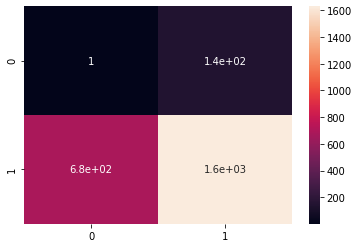

In [17]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

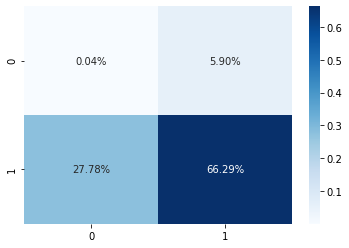

In [18]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [19]:
# https://github.com/DTrimarchi10/confusion_matrix
# https://matplotlib.org/examples/color/colormaps_reference.html
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

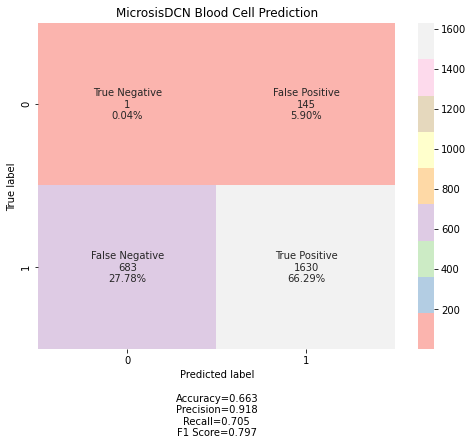

In [20]:
labels = ['True Negative','False Positive',
          'False Negative','True Positive']
categories = ['0','1']
make_confusion_matrix(cf_matrix, figsize=(8,6), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Pastel1', 
                      title='MicrosisDCN Blood Cell Prediction')